In [1]:
import networkx as nx
import statistics
import scipy.stats
import scipy.spatial.distance
import matplotlib.pyplot as plt
import os
import sys


# Given a NeworkX graph, determines the degree of each node 
# graph: NetworkX graph
# returns a dictionary of node:degree pairs
def get_degree(graph):
   deg_dict = {node: graph.degree(node) for node in graph.nodes()} 
   return deg_dict


# Given a NeworkX graph, determines the clustering coefficientof each node 
# graph: NetworkX graph
# Returns a dictionary of node:clustering coefficient pairs
def get_cc(graph):
    cc_dict  ={node: nx.clustering(graph,node) for node in graph.nodes()}
    return cc_dict

# Given a NeworkX graph, determines the average number of two hop neighbors (thn)
# of each node 
# graph: NetworkX graph
# Returns a dictionary of node:thn pairs
def get_thn(graph):
    thn_dict = {}
    for node in graph.nodes():
        neighbors = nx.all_neighbors(graph, node)
        mean_neighbor_degree = statistics.mean([nx.degree(graph, neighbor) for neighbor in neighbors])
        thn_dict[node] = mean_neighbor_degree
    return thn_dict

# Given a NeworkX graph, determines the average clustering coefficient of each 
# node's neighbors (ncc)
# graph: NetworkX graph
# Returns a dictionary of node:ncc pairs
def get_ncc(graph):
    ncc_dict = {}
    for node in graph.nodes():
        neighbors = nx.all_neighbors(graph, node)
        ncc = statistics.mean([nx.clustering(graph, neighbor) for neighbor in neighbors])
        ncc_dict[node] = ncc
    return ncc_dict

# Given a NeworkX graph, determines the number of edges in each node's egonet
# of each node (ee)
# graph: NetworkX graph
# Returns a dictionary of node:ncc pairs
def get_ee(graph):
    ee_dict = {node: len(nx.ego_graph(graph, node).edges()) for node in graph.nodes()}
    return ee_dict

# Given a NeworkX graph, determines the number of outgoing edges extending from the 
# egonet of each node (eeo)
# graph: NetworkX graph
# Returns a dictionary of node:eeo pairs
def get_eeo(graph):
    eeo_dict = {}
    for node in graph.nodes():
        src_nodes = set(nx.all_neighbors(graph, node))
        src_nodes.add(node)
        num_out_edges = 0
        for src_node in src_nodes:
            dst_nodes = set(nx.all_neighbors(graph,src_node))
            new_out_edges = dst_nodes.difference(src_nodes)
            num_out_edges += len(new_out_edges)
        eeo_dict[node] = num_out_edges
    return eeo_dict

# Given a NeworkX graph, determines the number of neighbors of each node's egonet (egn)
# graph: NetworkX graph
# Returns a dictionary of node:egn pairs
def get_egn(graph):
    egn_dict = {}
    for node in graph.nodes():
        egonet = set(nx.all_neighbors(graph, node))
        egonet.add(node)
        egonet_neighbors = set()
        for ego_node in egonet:
            neighbors = set(nx.all_neighbors(graph,ego_node))
            egonet_neighbors = egonet_neighbors.union(neighbors)
        filtered_neighbors = egonet_neighbors.difference(egonet)
        egn_dict[node] = len(filtered_neighbors)

    return egn_dict

# Given a NeworkX graph, performs the feature aggregation described in the NetSimile 
# algorithm
# graph: NetworkX graph
# Returns a feature signature vector for the graph
def aggregate_features(graph):
    f1 = get_degree(graph)
    f2 = get_cc(graph)
    f3 = get_thn(graph)   
    f4 = get_ncc(graph)   
    f5 = get_ee(graph)   
    f6 = get_eeo(graph)   
    f7 = get_egn(graph)   
    feature_matrix = [[f1[u], f2[u], f3[u], f4[u], f5[u], f6[u], f7[u]] for u in graph.nodes()]
    signature = []
    for feature in range(0, len(feature_matrix[0])):
        mean = statistics.mean([feature_matrix[row][feature] for row in range(0,len(feature_matrix))])
        median = statistics.median([feature_matrix[row][feature] for row in range(0,len(feature_matrix))])
        stdev = statistics.stdev([feature_matrix[row][feature] for row in range(0,len(feature_matrix))])
        skewness = scipy.stats.skew([feature_matrix[row][feature] for row in range(0,len(feature_matrix))])
        kurtosis = scipy.stats.kurtosis([feature_matrix[row][feature] for row in range(0,len(feature_matrix))])
        feature_set = [mean,median,stdev,skewness,kurtosis]
        signature += feature_set
    return signature

# Given a time series of distances between adjacent veectors, returns the calculated
# threshold for identifying out of family measurements,
# distances: a list of distances between adjacent vectors
# Returns a tuple of lower and upper thresholds
def get_thresholds(distances):
    moving_range = 0
    for i in range(0, len(distances) - 1):
        moving_range += abs(distances[i] - distances[i+1])
    moving_range_avg = moving_range / (len(distances) - 1)
    median = statistics.median(distances)
    return (median - (3 * moving_range_avg), median + (3 * moving_range_avg))

# Given the relative path to a directory of edgelists, reads each edgelist one-
# by-one, and builds a NetworkX graph.  
# input_directory: relative path to directory of graph files
# Returns a list of graphs sorted by name index
def read_files(input_directory):
    graphs = {}
    sorted_graphs = []
    listing = os.listdir(input_directory)
    file_count = len(listing)
    file_index = 1
    for file in listing:
        path = input_directory + file
        id = int(file.split('_')[0])
        graphs[id] = read_graph(path)
        show_progress('Reading graphs: ',file_index, file_count)
        file_index += 1
    print('')
    sorted_keys = sorted(graphs)
    for key in sorted_keys:
        sorted_graphs.append(graphs[key])
    return sorted_graphs

# Given a file path, reads the file and returns a NetworkX graph 
# infile: full path to an edgelist
# Note: This method ignores the first line as the node/edge count
# is not used for NetworkX
# Returns a NetworkX graph
def read_graph(infile):
    file = open(infile, 'r')
    
    # throw away first line
    file.readline()

    graph=nx.parse_edgelist(file, nodetype=int)
    return graph

# Given a time series of distances between adjacent signature vectors,
# a threshold, writes a graph image to the specified imagefile.
# distances: a list of distances between adjacent vectors
# UCL: upper threshold for determining out of family values
# imagefile: output file
def draw_plot(distances, UCL, imagefile):
    fig = plt.figure()
    plt.plot(distances, '-+')
    plt.axhline(y=UCL,c='g')
    plt.title('Similarity (Canberra Distance) vs Time for P2P-Gnutella Data')
    plt.xlabel('Time')
    plt.ylabel("Similarity")
    #plt.show()
    plt.savefig(imagefile)

# Given a time series of distances between adjacent signature vectors,
# and an output data file, writes a summary to the datafile.
# distances: a list of distances between adjacent vectors
# datafile: output data file
def write_data(distances, datafile):
    file = open(datafile,'w')
    for index, distance in enumerate(distances):
        file.write('%s %s\n' % (index, distance))
    file.close

# Given the current progress of an incrementer, prints a percentage
# progress to stdout.
# state: string representing current operation
# index: current index of incrementer
# count: end index of incrementer
def show_progress(state,index, count):
    percentage = float(index) / float(count) * 100
    sys.stdout.write('\r%s %d%% Complete' % (state, percentage))
    sys.stdout.flush()

In [2]:
%reload_ext autoreload
%autoreload
%matplotlib inline
from myHelper import timing
from myHelper import GraphSignalHelper
import numpy as np
from myHelper import db_helper

DB_dir ='./mitbih-database/'
p_id = '106'
r_detect = 'two_aver'
    
data_df = db_helper.read_heartbeat_database(DB_dir, p_id, nRowsRead=None)
annotations_df = db_helper.read_annotation_database(DB_dir, p_id)

# downsampling the signal
downstep = 2
(downsp_data_df, downsp_annotations_df) = GraphSignalHelper.downsample(data_df,
                                                               annotations_df,
                                                               downstep)
# # split the the signal into heartbeat using the R-peak detection
# heart_beats, hbs_annotations = GraphSignalHelper.heartbeat_spliting(downsp_data_df, 
#                                                     downsp_annotations_df,
#                                                     R_detector=r_detect,
#                                                     fs = (360 / downstep))
# split the the signal into (fixed) heartbeat using the R-peak detection
heart_beats, hbs_annotations = GraphSignalHelper.fixed_heartbeat_spliting(downsp_data_df, 
                                                    downsp_annotations_df,
                                                    R_detector=r_detect,
                                                    fs = (360 / downstep))

# labeling heartbeats by looking at their annotations into 
# (-1) or (1) for Anomalous or Normal
hb_labels = GraphSignalHelper.anomaly_labels(hbs_annotations)


graph_stream, graph_stream_labels = GraphSignalHelper.generate_graph_stream(heart_beats, 
                                                                            hb_labels)
len(graph_stream)
# 2081

2086

In [3]:
import networkx as nx
print(nx.info(graph_stream[0]))

Name: 
Type: Graph
Number of nodes: 154
Number of edges: 1278
Average degree:  16.5974


In [5]:
graphs = []
signatures = []
distances = []
anomalies = []

sorted_graphs = []
sorted_keys = sorted(graph_stream)
for key in sorted_keys:
    sorted_graphs.append(graph_stream[key])
    
graphs = sorted_graphs

for index, graph in enumerate(graphs):
    signature = aggregate_features(graph)
    signatures.append(signature)
    show_progress('Aggregating features: ',index + 1, len(graphs))

Aggregating features:  100% Complete

In [4]:
from myHelper import dis_mat
vec_dis_mat = dis_mat.cal_vec_dist_mat(heart_beats)
print("precomputed vector distance matrix =\n",vec_dis_mat)

<frozen importlib._bootstrap>:219: UserWarning: To obtain optimal results install the Cython 'munkres' module at  https://github.com/jfrelinger/cython-munkres-wrapper


cal_vec_dist_mat took 189.01705741882324   mil sec
precomputed vector distance matrix =
 [[   0.          180.77610462  225.87164497 ...  475.93381893
  1126.14608289 1576.26774375]
 [ 180.77610462    0.          186.04300578 ...  444.75049185
  1096.26867145 1554.32686395]
 [ 225.87164497  186.04300578    0.         ...  423.94457185
  1113.37819271 1509.37934264]
 ...
 [ 475.93381893  444.75049185  423.94457185 ...    0.
  1116.78108867 1471.34530278]
 [1126.14608289 1096.26867145 1113.37819271 ... 1116.78108867
     0.         1605.32270899]
 [1576.26774375 1554.32686395 1509.37934264 ... 1471.34530278
  1605.32270899    0.        ]]


In [5]:
vec_dis_mat.shape

(2086, 2086)

In [9]:
from sklearn.metrics.pairwise import euclidean_distances
sig_dis_mat = euclidean_distances(signatures, signatures)

In [6]:
# np.save('sig_dis_mat_106_downstep2', sig_dis_mat)
sig_dis_mat = np.load('sig_dis_mat_106_downstep2.npy')

In [7]:
sig_dis_mat.shape

(2086, 2086)

In [4]:
ged_dis_mat = np.load('ged_dis_mat_106_approximate_ged.npy')

In [5]:
from myHelper import anomaly_detection
graph_y_pred, graph_y_scores = anomaly_detection.ged_out_det_dis_mat(ged_dis_mat,
                                                        n_process= -1)


 Outlier threshold -(clf.offset_) =  1.3363591373011303 


ged_out_det_dis_mat took 71.02799415588379   mil sec



Number of errors =  543

accuracy = 0.7391
precision  0.7498
recall  0.9755
F1 score on Test 0.8479
(ROC AUC) Score =  0.4848801138644575


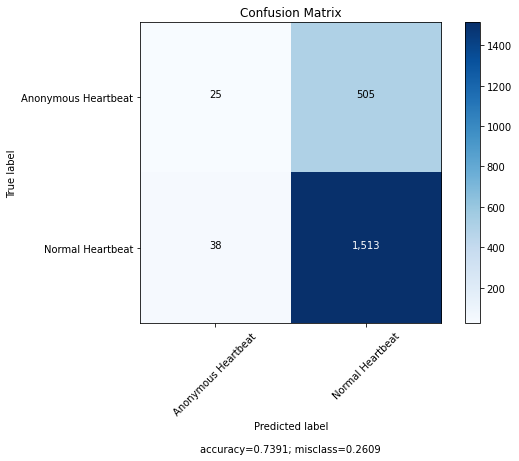

In [6]:
anomaly_detection.anomaly_plotter(graph_stream_labels, graph_y_pred, graph_y_scores)

vec_out_det_dis_mat took 111.38606071472168   mil sec

Number of errors =  690

accuracy = 0.6692
precision  0.7597
recall  0.8144
F1 score on Test 0.7861
(ROC AUC) Score =  0.6398956842262458


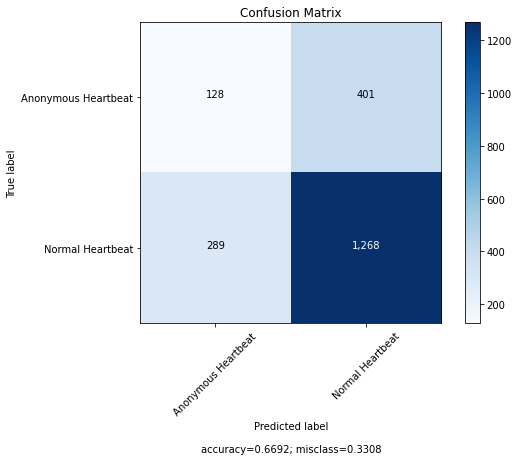

In [8]:
from myHelper import anomaly_detection

vector_y_pred, vector_y_scores = anomaly_detection.vec_out_det_dis_mat(vec_dis_mat,
                                                        n_process= -1)
anomaly_detection.anomaly_plotter(hb_labels, vector_y_pred, vector_y_scores)

vec_out_det_dis_mat took 121.4909553527832   mil sec

Number of errors =  462

accuracy = 0.7785
precision  0.828
recall  0.8876
F1 score on Test 0.8568
(ROC AUC) Score =  0.8385679406254818


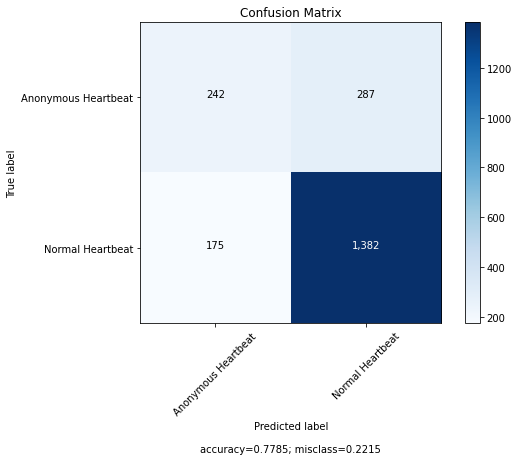

In [9]:
from myHelper import anomaly_detection

sig_y_pred, sig_y_scores = anomaly_detection.vec_out_det_dis_mat(sig_dis_mat,
                                                        n_process= -1)
anomaly_detection.anomaly_plotter(hb_labels, sig_y_pred, sig_y_scores)

In [10]:
from myHelper import anomaly_detection
(vec_y_pred, 
 vec_y_scores, 
 vec_threshold, 
 ged_y_pred, 
 ged_y_scores, 
 ged_threshold) = anomaly_detection.combine_OD_dis(vec_dis_mat,
                                                  sig_dis_mat,
                                                  vec_n_neighbors=200,
                                                  vec_c =0.2,
                                                  ged_n_neighbors=4,
                                                  ged_c=0.03)

In [11]:
vec_threshold

-1.3744085451408439

In [12]:
ged_threshold

-1.3947977132510254

In [13]:
vec_y_scores

array([-1.0506874 , -1.04938651, -0.99624362, ..., -1.08583482,
       -1.22089281, -1.01715995])

In [14]:
vec_y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [15]:
combine_score = vec_y_scores+ged_y_scores
combine_score

array([-2.02395085, -2.06896207, -1.94121793, ..., -2.17461518,
       -2.2292288 , -2.07522885])

In [16]:
combine_threshold = vec_threshold + ged_threshold
combine_threshold

-2.7692062583918693

In [17]:
combine_y_pred = [-1 if(score<combine_threshold) else 1 for score in combine_score]


Number of errors =  705

accuracy = 0.662
precision  0.7348
recall  0.8561
F1 score on Test 0.7909
(ROC AUC) Score =  0.6176180988838746


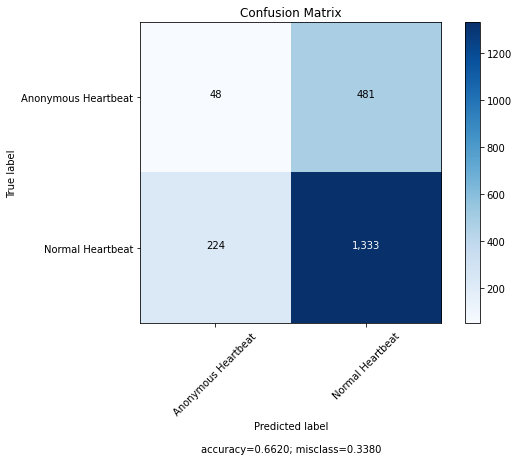

In [18]:
from myHelper import anomaly_detection
anomaly_detection.anomaly_plotter(hb_labels, combine_y_pred, combine_score)

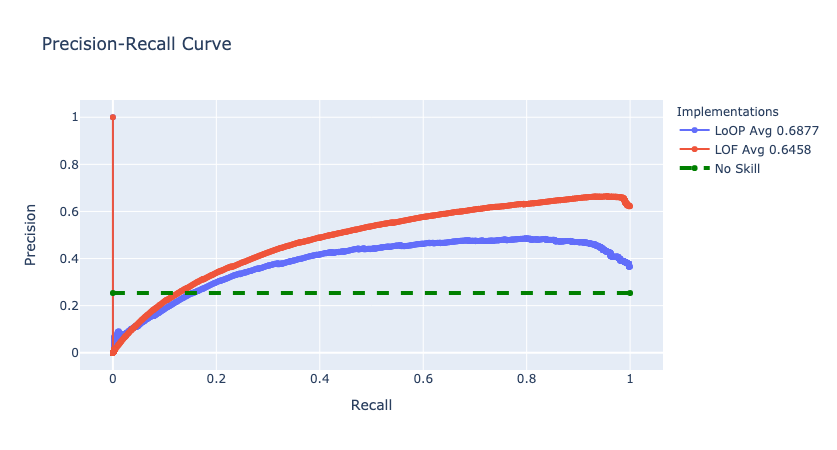

In [19]:
from myHelper import analytics
from myHelper import anomaly_detection

y_zero_one = anomaly_detection.zero_one_label_converter(hb_labels)

analytics.my_pre_recall(vec_dis_mat,
                        hb_labels,
                        y_zero_one,
                        n_neighbors=400,
                        contamination = 0.25,
                        n_process = -1)

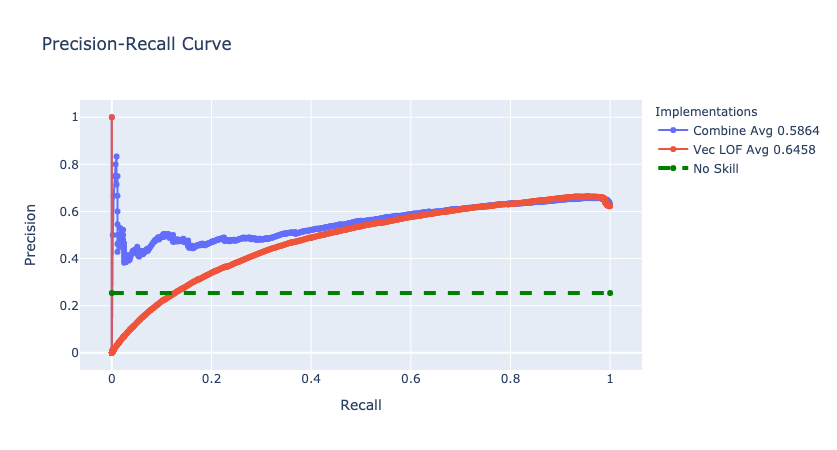

In [20]:
from myHelper import analytics
from myHelper import anomaly_detection

y_zero_one = anomaly_detection.zero_one_label_converter(hb_labels)

# analytics.my_pre_recall(vec_dis_mat,
#                         hb_labels,
#                         y_zero_one,
#                         n_neighbors=500,
#                         contamination = 0.25,
#                         n_process = -1)
analytics.combine_pre_recall(vec_dis_mat,
                             sig_dis_mat,
                             hb_labels,
                             y_zero_one,
                             vec_n_neighbors=400,
                             vec_c =0.27,
                             ged_n_neighbors=400,
                             ged_c=0.27,
                             n_process = -1)

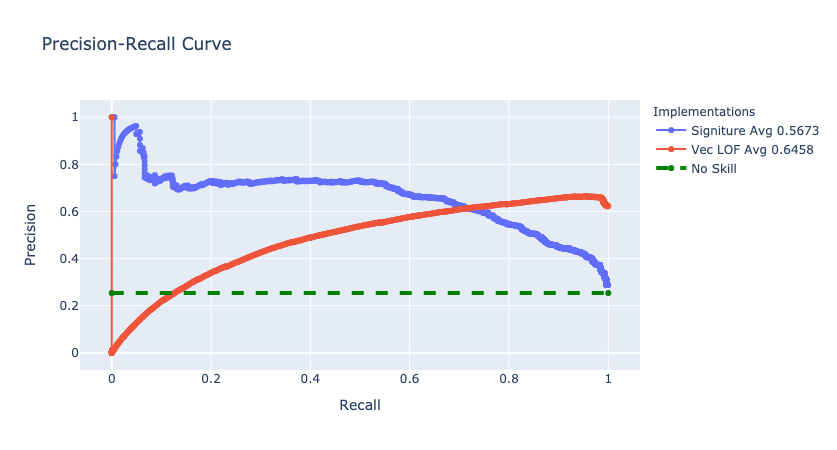

In [30]:
from myHelper import analytics
from myHelper import anomaly_detection

y_zero_one = anomaly_detection.zero_one_label_converter(hb_labels)

# analytics.my_pre_recall(vec_dis_mat,
#                         hb_labels,
#                         y_zero_one,
#                         n_neighbors=500,
#                         contamination = 0.25,
#                         n_process = -1)
analytics.sig_pre_recall(vec_dis_mat,
                         sig_dis_mat,
                         hb_labels,
                         y_zero_one,
                         vec_n_neighbors=400,
                         vec_c =0.27,
                         sig_n_neighbors=400,
                         sig_c=0.27,
                         n_process = -1)

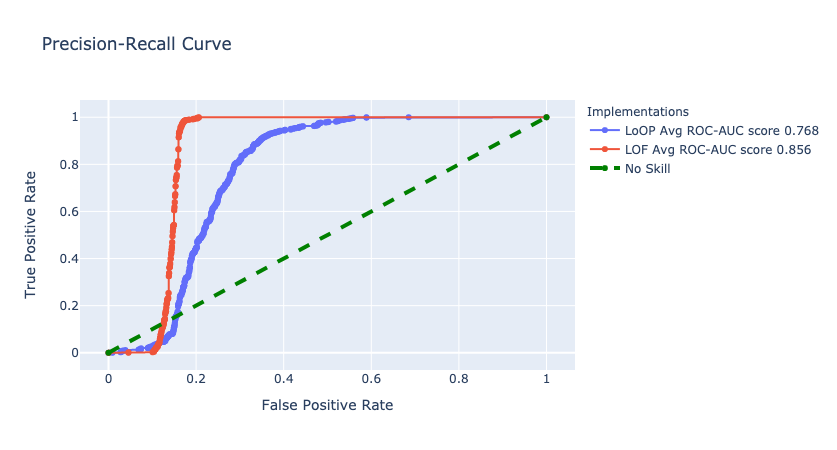

In [28]:
from myHelper import analytics
from myHelper import anomaly_detection

y_zero_one = anomaly_detection.zero_one_label_converter(hb_labels)

analytics.my_roc_curve(vec_dis_mat,
                       hb_labels,
                       y_zero_one,
                       n_neighbors=400,
                       contamination = 0.27,
                       n_process = -1)

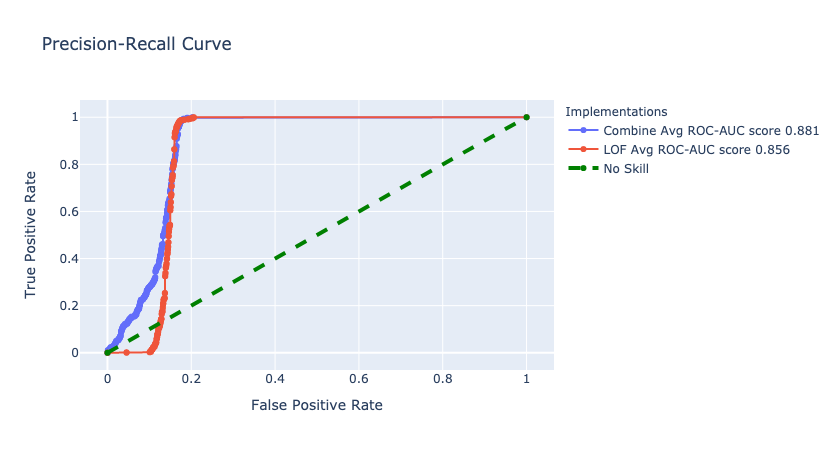

In [29]:
from myHelper import analytics
from myHelper import anomaly_detection

y_zero_one = anomaly_detection.zero_one_label_converter(hb_labels)

analytics.combine_roc_curve(vec_dis_mat,
                            sig_dis_mat,
                            hb_labels,
                            y_zero_one,
                            vec_n_neighbors=400,
                            vec_c =0.27,
                            ged_n_neighbors=400,
                            ged_c=0.27,
                            n_process = -1)

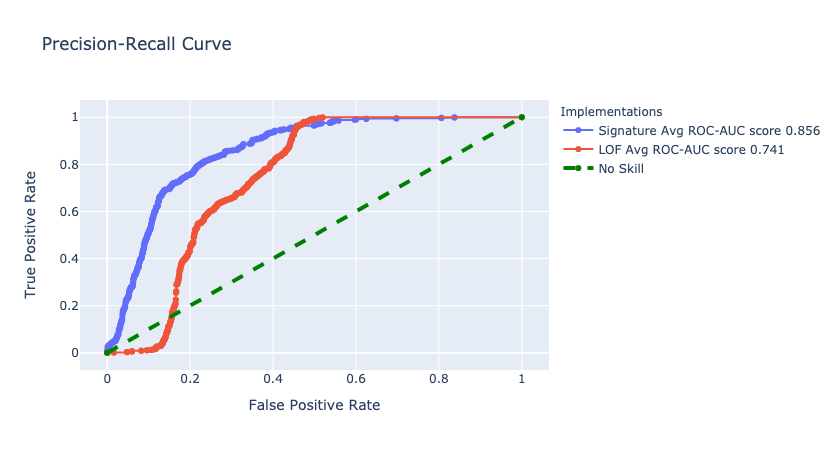

In [63]:
from myHelper import analytics
from myHelper import anomaly_detection

y_zero_one = anomaly_detection.zero_one_label_converter(hb_labels)

analytics.sig_roc_curve(vec_dis_mat,
                            sig_dis_mat,
                            hb_labels,
                            y_zero_one,
                            vec_n_neighbors=250,
                            vec_c =0.00001,
                            sig_n_neighbors=250,
                            sig_c=0.00001,
                            n_process = -1)